Unified for all the PT regions

In [1]:
class Bauble: pass
cat = Bauble()

In [2]:
# cat.name = 'High'
# cat.min_pt = 12
# cat.max_pt = 1e4
# cat.trg = 'Mu12_IP6'
# cat.minIP = 6

In [3]:
# cat.name = 'Mid'
# cat.min_pt = 9
# cat.max_pt = 12
# cat.trg = 'Mu9_IP6'
# cat.minIP = 6

In [4]:
cat.name = 'Low'
cat.min_pt = 7
cat.max_pt = 9
cat.trg = 'Mu7_IP4'
cat.minIP = 4

### Imports

In [5]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
from multiprocessing import Pool
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [6]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [7]:
import operator
ops = {'>': operator.gt, '<': operator.lt, '=': operator.eq, '==': operator.eq}

In [8]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [9]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Cuts declaration

In [10]:
trigger_cuts = [
 'trgMu_HLT_{} == 1'.format(cat.trg),
 'trgMu_pt > ' + str(cat.min_pt),
 'trgMu_pt < '+ str(cat.max_pt),
 'trgMu_sigdxy > ' + str(cat.minIP),
 'trgMu_eta < 1.5',
 'trgMu_eta > -1.5'
]

offline_cuts = [
 'mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 4.5',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5.01',
 'mass_mumupiK < 5.56'
]

analysis_cuts = trigger_cuts + offline_cuts
analysis_cuts_str = ' && '.join(analysis_cuts)

In [11]:
def event_trg_selection(j, ev):
    for c_str in trigger_cuts:
        aux = c_str.split(' ')
        if len(aux) != 3: 
            print aux
            raise
        x = getattr(ev, aux[0])[j]
        if not ops[aux[1]](x, float(aux[2])):
            return False
    return True

In [12]:
def candidate_selection(j, ev):
    accept = abs(ev.mass_piK[j] - 0.895) < abs(ev.mass_piK_CPconj[j] - 0.895)
    for c_str in offline_cuts:
        if c_str == 'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)': 
            continue
        if not accept:
            break
        aux = c_str.split(' ')
        if len(aux) != 3:
            print aux
            raise
        x = getattr(ev, aux[0])[j]
        accept = ops[aux[1]](x, float(aux[2]))
    return accept

# Load data

In [13]:
dataDir = '../data/cmsRD'
datasets_loc = []
datasets_loc += glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_200124*')

for d in datasets_loc: print d

../data/cmsRD/ParkingBPH3/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH3/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH2/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH2/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH5/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH5/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH4/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH4/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH1/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124_CAND.root
../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124_CAND.root


In [14]:
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part2_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part2_v2 0.66
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part1_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part1_v2 1.24
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part4_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part4_v2 1.23
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part3_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part3_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part0_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part0_v2 1.24
Total lumi: 5.80 fb^-1


### Create a skimmed tree

In [15]:
def skim_dset(dset_loc, isRD=True):
    start_time = time.time()
    output = []
    N_accepted_cand = []
    N_accepted_trgMu = []
    nMax = 1e12
    if isRD:
        idx = dset_loc.find('BPH')
        part = dset_loc[idx+3]
        idx = dset_loc.find('Run2018')
        era = dset_loc[idx+7]
        f = rt.TFile(dset_loc, 'READ')
        aux_tree = f.Get('outA/Tevts')
        aux = dset_loc.split('/')
        fname = '../data/cmsRD/skimmed/B2JpsiKst_Mu{}_{}_{}.root'.format(cat.min_pt, aux[-2], aux[-1][:-10])
    else:
        fname = '../data/cmsMC_private/skimmed/B2JpsiKst_Mu{}.root'.format(cat.min_pt)
        aux_tree = dset_loc
        part = 'MC'
        era = ''
    maxEntry=float(min(nMax, aux_tree.GetEntries()))
    for i_ev, ev in enumerate(aux_tree): 
        if i_ev >= nMax:
            break
        if i_ev % 100000 == 0:
            print era+part, ': {:.0f} %'.format(100*i_ev/maxEntry)
        N_acc = 0
        
        idx_trgMu = -1
        trgMu_pt = -1
        N_trgMu = 0
        for j in range(ev.trgMu_pt.size()):
            if event_trg_selection(j, ev):
                N_trgMu += 1
                if ev.trgMu_pt[j] > trgMu_pt:
                    trgMu_pt = ev.trgMu_pt[j]
                    idx_trgMu = j
                
        if N_trgMu == 0: 
            continue

        for j in range(ev.pval_mumupiK.size()):
            if not candidate_selection(j, ev):
                continue
            
            N_acc += 1
            aux_out = (ev.mass_mumupiK[j], 
                       ev.B_mumupiK_pt[j], 
                       ev.B_mumupiK_eta[j],
                       ev.Jpsi_pt[j],
                       ev.Kst_pt[j],
                       ev.trgMu_pt[idx_trgMu],
                       ev.trgMu_sigdxy[idx_trgMu],
                       ev.mum_pt[j],
                       ev.mum_eta[j],
                       ev.mum_isTrg[j],
                       ev.mup_eta[j],
                       ev.mup_pt[j],
                       ev.mup_isTrg[j],
                       ev.N_vertexes
                      )
            if not isRD:
                aux_out += (ev.MC_B_pt,
                            ev.MC_idxCand == j
                           )
            output.append(aux_out)
        if N_acc > 0:
            N_accepted_cand.append(N_acc)
            N_accepted_trgMu.append(N_trgMu)
    print era+part, ': loop done'
    
    import root_numpy as rtnp
    leafs_names = ['mass_mumupiK', 'B_pt', 'B_eta', 
                   'Jpsi_pt', 'Kst_pt',
                   'trgMu_pt', 'trgMu_sigdxy', 
                   'mum_pt', 'mum_eta', 'mum_isTrg', 
                   'mup_eta', 'mup_pt', 'mup_isTrg', 
                   'N_vtx'
                  ]
    if not isRD:
        leafs_names += ['MC_B_pt', 'idxCandMatch']
    dtypes = []
    for n in leafs_names:
        dtypes.append((n, np.float32))

    a = np.array(output, dtype=dtypes)
    rtnp.array2root(a, fname, treename='Tevts', mode='RECREATE')
    print era+part, ': root dumped'
    
    dicMu = {i:N_accepted_trgMu.count(i) for i in range(1, np.max(N_accepted_trgMu)+1)}
    print era+part, 'trgMu:', dicMu
    dicCand = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
    print era+part, 'Cand:', dicCand
    print era+part, 'done in {:.0f} min'.format((time.time() - start_time)/60.)
    return fname, dicMu, dicCand

In [16]:
recreate = True
if recreate:
    p = Pool(len(datasets_loc))
    out = p.map(skim_dset, datasets_loc) 

C5 : 0 %
C4 : 0 %
C1 : 0 %
C3 : 0 %
C2 : 0 %
D3 : 0 %
D4 : 0 %
D2 : 0 %
D5 : 0 %
D1 : 0 %
C4 : 3 %
C3 : 3 %
C5 : 3 %
C2 : 3 %
C1 : 3 %
D5 : 1 %
D4 : 1 %
D1 : 1 %
D3 : 1 %
D2 : 1 %
C4 : 7 %
C5 : 7 %
C3 : 7 %
C2 : 7 %
C1 : 7 %
D4 : 1 %
D1 : 1 %
D3 : 3 %
D5 : 1 %
C3 : 10 %
C5 : 10 %
C2 : 10 %
D2 : 1 %
C4 : 10 %
D4 : 2 %
C1 : 10 %
D3 : 4 %
C5 : 14 %
C2 : 14 %
D1 : 2 %
D4 : 2 %
D5 : 2 %
C3 : 14 %
C1 : 14 %
C4 : 14 %
C5 : 17 %
D2 : 2 %
C2 : 17 %
C3 : 17 %
D5 : 3 %
D1 : 3 %
C4 : 17 %
D3 : 5 %
D4 : 3 %
C5 : 21 %
C1 : 17 %
D2 : 3 %
C2 : 21 %
D5 : 3 %
C3 : 21 %
D4 : 4 %
C5 : 24 %
C4 : 21 %
C1 : 21 %
D3 : 6 %
C2 : 24 %
D2 : 3 %
D1 : 3 %
C3 : 24 %
C4 : 24 %
D5 : 4 %
C1 : 24 %
D3 : 8 %
C5 : 27 %
D1 : 4 %
C2 : 28 %
D2 : 4 %
D4 : 4 %
C4 : 28 %
C1 : 27 %
D3 : 9 %
C3 : 28 %
D5 : 5 %
C5 : 31 %
C2 : 31 %
D1 : 4 %
C4 : 31 %
C1 : 31 %
D3 : 10 %
D4 : 5 %
C3 : 31 %
D2 : 5 %
D5 : 5 %
C2 : 35 %
C5 : 34 %
C4 : 34 %
C1 : 34 %
D1 : 5 %
D3 : 12 %
C3 : 35 %
D4 : 6 %
D2 : 5 %
C2 : 38 %
C5 : 38 %
C4 : 38 %
C1 : 38 %


D2 : 88 %
D4 : 83 %
D5 : 88 %
D1 : 87 %
D4 : 83 %
D5 : 89 %
D2 : 89 %
D4 : 84 %
D1 : 88 %
D4 : 85 %
D1 : 89 %
D5 : 89 %
D2 : 90 %
D4 : 85 %
D1 : 89 %
D5 : 90 %
D2 : 90 %
D4 : 86 %
D1 : 90 %
D4 : 86 %
D2 : 91 %
D1 : 91 %
D5 : 91 %
D4 : 87 %
D2 : 92 %
D5 : 91 %
D4 : 88 %
D1 : 91 %
D5 : 92 %
D2 : 92 %
D1 : 92 %
D4 : 88 %
D5 : 93 %
D2 : 93 %
D4 : 89 %
D5 : 93 %
D1 : 92 %
D4 : 89 %
D2 : 94 %
D1 : 93 %
D4 : 90 %
D5 : 94 %
D2 : 94 %
D1 : 94 %
D4 : 91 %
D5 : 95 %
D2 : 95 %
D4 : 91 %
D1 : 94 %
D5 : 95 %
D4 : 92 %
D2 : 95 %
D1 : 95 %
D5 : 96 %
D4 : 93 %
D2 : 96 %
D1 : 96 %
D4 : 93 %
D2 : 97 %
D5 : 96 %
D1 : 96 %
D4 : 94 %
D1 : 97 %
D4 : 94 %
D5 : 97 %
D2 : 97 %
D1 : 98 %
D4 : 95 %
D5 : 98 %
D1 : 98 %
D2 : 98 %
D1 : 99 %
D4 : 96 %
D5 : 98 %
D2 : 99 %
D4 : 96 %
D1 : 99 %
D5 : 99 %
D2 : 99 %
D1 : loop done
D1 : root dumped
D1 trgMu: {1: 2656, 2: 175, 3: 2}
D1 Cand: {1: 2828, 2: 5}
D1 done in 31 min
D4 : 97 %
D5 : 100 %
D5 : loop done
D5 : root dumped
D5 trgMu: {1: 2545, 2: 166, 3: 1}
D5 Cand: {1: 2

In [17]:
skimmed_tree = rt.TChain('Tevts')

for n in datasets_loc:
    aux = n.split('/')
    fname = '../data/cmsRD/skimmed/B2JpsiKst_Mu{}_{}_{}.root'.format(cat.min_pt, aux[-2], aux[-1][:-10])
    skimmed_tree.Add(fname)
    
N_sel_per_fb = skimmed_tree.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 2242


# Analyze data

### Fit the whole dataset

In [18]:
width = 0.005 #GeV
m_min = 5.05
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=np.arange(start=m_min, stop=5.5, step=width)
               )
skimmed_tree.Project('h', 'mass_mumupiK')
h.Sumw2()

In [19]:
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', m_min, m_max, 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.00005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [20]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [21]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

chi2: 88.5/83 0.319
Total: Nsig = 9606, Nbkg = 2646
Signal events per fb: 1656


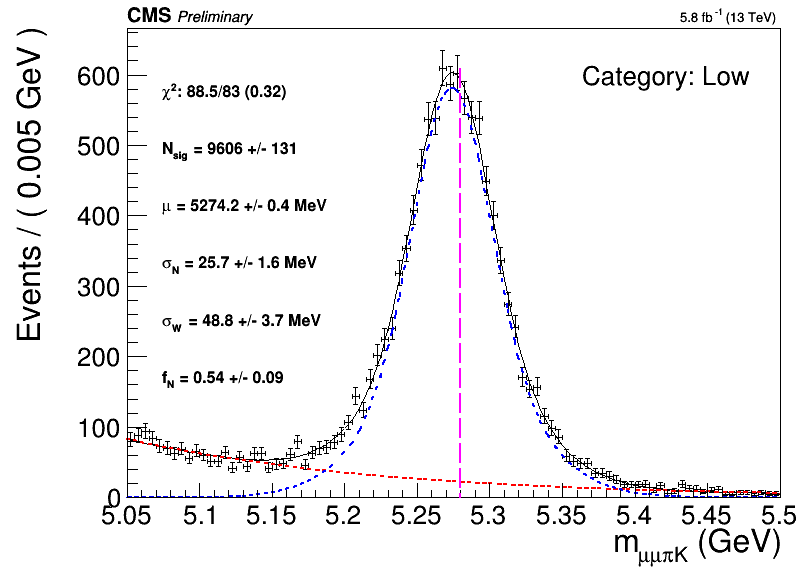

In [22]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

text = rt.TLatex()
text.SetTextAlign(31)
text.SetTextSize(0.06)
text.SetTextFont(42)
text.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()
text.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name));
# c.SetLogy()

### Make sDataset

In [23]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_trgMu_pt = rt.RooRealVar('trgMu_pt', '#mu_{trg} p_{T}', 0, 1000, 'GeV')
v_N_vtx = rt.RooRealVar('N_vtx', 'N_{vtx}', 0, 1e3)

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', skimmed_tree, rt.RooArgSet(mass, v_B_eta, v_B_pt, v_trgMu_pt, v_N_vtx))
ds.convertToTreeStore()

In [24]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

9606.865625135024

In [25]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_Mu{}_sw.root'.format(cat.min_pt), 'RECREATE')
ds.convertToTreeStore()
treeRD_skimmed = ds.tree()
treeRD_skimmed.Write()
f_sw.Close()

In [26]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_Mu{}_sw.root'.format(cat.min_pt), 'READ')
treeRD_skimmed = f_sw.Get('merged')
# treeRD_skimmed.Print()

# Load MC

In [ ]:
mcDir = '../data/cmsMC_private/'
mcDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
mcsets_loc = glob(mcDir + '/ntuples_B2JpsiKst/out_CAND*.root')
treeMC = rt.TChain('outA/Tevts')
for floc in mcsets_loc:
    treeMC.Add(floc)

recreate = True
fname = '../data/cmsMC_private/skimmed/B2JpsiKst_Mu{}.root'.format(cat.min_pt)
if recreate or not os.path.isfile(fname):
    skim_dset(treeMC, isRD=False)
f_treeMC_skimmed = rt.TFile(fname, 'READ')
treeMC_skimmed = f_treeMC_skimmed.Get('Tevts')
    
N_cand = treeMC.GetEntries()
N_sel = treeMC_skimmed.GetEntries()
print 'N files: {:.0f}'.format(len(mcsets_loc))
print 'N evts candidate: {:.0f}'.format(N_cand)
print 'N evts selected: {:.0f}'.format(N_sel)
e = N_sel/float(N_cand)
analysisSelEff = [e, np.sqrt(e*(1-e)/N_cand)]

MC : 0 %
MC : 19 %
MC : 38 %


In [ ]:
dic_MCeff = pickle.load(open(mcDir+'/efficiency.pickle', 'rb'))
dic_decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [ ]:
xsec_eff = dic_MCeff['xsec'][0]
print 'Pythia xsec: {:1.2e} fb'.format(xsec_eff)
xsec_eff *= dic_decayBR['JPsiKst'][0]
print 'Forced decays BR: {:1.2e}'.format(dic_decayBR['JPsiKst'][0])
xsec_eff *= dic_MCeff['CMSSWFilterEff'][0]
print'Eff CMSSW filter: {:1.2e}'.format(dic_MCeff['CMSSWFilterEff'][0])
xsec_eff *= dic_MCeff['ntupplizerEff'][0]
print'Eff ntuplizer: {:1.2e}'.format(dic_MCeff['ntupplizerEff'][0])
xsec_eff *= analysisSelEff[0]
print'Eff selection: {:1.2e}'.format(analysisSelEff[0])
d2xsec = 0
for f, e in dic_MCeff.values() + [analysisSelEff, dic_decayBR['JPsiKst']]:
    d2xsec += (e/f)**2
dxsec = np.sqrt(d2xsec) * xsec_eff
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'

print 'Ratio with observed: {:.0f}/{:.0f} = {:.2f}'.format(xsec_eff, N_sig_per_fb, xsec_eff/N_sig_per_fb)

# Analyze MC

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=array('d', list(np.arange(start=5.15, stop=5.37, step=0.005)) + [5.38, 5.4])
               )
treeMC_skimmed.Project('h', 'mass_mumupiK')
h.Sumw2()
N_tot = h.Integral(1, h.GetNbinsX())

In [ ]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[0], h.binning[-1], 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.00005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)


nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [ ]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = pdf_sig_ext
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX() - fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

In [ ]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))

pTxt = rt.TPaveText(h.GetBinCenter(1), 0.2*h.GetMaximum(), h.GetBinCenter(int(0.35*h.GetNbinsX())), h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = ''
c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

# Compare

### Closure variables

In [ ]:
b=[50, 0.5, 50.5]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=b
               )
treeRD_skimmed.Project('hRD', 'N_vtx', 'L_nsig/(L_nsig+L_nbkg)')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
treeMC_skimmed.Project('hMC', 'N_vtx')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.extraText = '     Preliminary'
CMS_lumi.integrated_lumi = lumi_tot
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()

In [ ]:
b=[50, 5.15, 5.4]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b
               )
treeRD_skimmed.Project('hRD', 'mass_mumupiK', 'L_nsig/(L_nsig+L_nbkg)')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
treeMC_skimmed.Project('hMC', 'mass_mumupiK')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.extraText = '     Preliminary'
CMS_lumi.integrated_lumi = lumi_tot
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()

### The true B spectrum

In [ ]:
b = [30, 9, 60.]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data_{sW}',
                axis_title=['B_{0} p_{T} (reco) [GeV]', 
                            '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b,
                opt='overflow+underflow'
               )
treeRD_skimmed.Project('hRD', 'B_pt', 'nsig_sw')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
treeMC_skimmed.Project('hMC', 'B_pt')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.2, 20], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad2.cd()
ln = rt.TLine()
ln.SetLineStyle(7)
ln.SetLineColor(1)
ln.DrawLine(hRD.binning[1], 1, hRD.binning[2], 1)

c.pad1.cd()
text.SetTextSize(0.04)
text.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name));

In [ ]:
uncertainty = 0.3
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb(x, value_at_beg):
    center = 0.5*(hRD.binning[2] + hRD.binning[1])
    k = (value_at_beg-1)/(hRD.binning[1] -  center)
    return k*(x - center)+1

fout = open('../data/calibration/B02JPsiKst_Mu{}_pt.txt'.format(cat.min_pt), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    
    dic['wUp'].append(r * f_arb(pt, 1. - uncertainty))
    dic['wDown'].append(r * f_arb(pt, 1. + uncertainty))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, r * f_arb(pt, 1. - uncertainty), r * f_arb(pt, 1. + uncertainty)]))+'\n')
fout.close()

In [ ]:
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best')
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.text(40,ymax*0.9, 'Category: ' + cat.name);

In [ ]:
h_var = {}
colors = [5,6,8]
for k in ['central', 'up', 'down']:
    h_var[k] = hMC.Clone('hMC_'+k)
    h_var[k].SetTitle(k)
    h_var[k].SetLineColor(colors[0])
    h_var[k].SetMarkerColor(colors[0])
    h_var[k].SetMarkerStyle(rt.kCircle)
    colors.pop(0)
    
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = hMC.GetBinContent(ib)
    y_err = hMC.GetBinError(ib)
    h_var['central'].SetBinContent(ib, y*dic['w'][ib-1])
    h_var['central'].SetBinError(ib, y_err*dic['w'][ib-1])
    h_var['up'].SetBinContent(ib, y*dic['wUp'][ib-1])
    h_var['up'].SetBinError(ib, y_err*dic['wUp'][ib-1])
    h_var['down'].SetBinContent(ib, y*dic['wDown'][ib-1])    
    h_var['down'].SetBinError(ib, y_err*dic['wDown'][ib-1])
for h in h_var.values():
    h.Scale(1./h.Integral())
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['central'].GetBinContent(ib)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['central'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['up'].GetBinContent(ib), y-h_var['down'].GetBinContent(ib))
    dy_up = max(h_var['up'].GetBinContent(ib)-y, h_var['down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
gr_stat.SetLineColor(6)
gr_stat.SetMarkerColor(6)
gr_sys.SetFillColor(6)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia reweighted', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

hRD.GetYaxis().SetRangeUser(0, .15)
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC, gr_stat, gr_sys], ['', 'same', 'p', '2'])
leg.Draw()
text.DrawLatexNDC(0.95, 0.6, 'Category: '+cat.name);

In [ ]:
b=[50, 10, 100, 50, 10, 100]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=b
               )
treeMC_skimmed.Project('hMC', 'B_pt:MC_B_pt', 'idxCandMatch')

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

In [ ]:
b=[50, 10, 100, 50, -5, 5]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', ''],
                binning=b
               )
treeMC_skimmed.Project('hMC', 'B_pt - MC_B_pt:MC_B_pt', 'idxCandMatch')

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

In [ ]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
cal_pT = PTCalibration(calibration_file='../data/calibration/B02JPsiKst_Mu{}_pt.txt'.format(cat.min_pt))

In [ ]:
fname = '../data/cmsMC_private/skimmed/B2JpsiKst_Mu{}.root'.format(cat.min_pt)
dSet_MC = rtnp.root2array(fname)
h_var = {}
colors = [5,6,8]
for k in ['C', 'Up', 'Down']:
    sel = dSet_MC['idxCandMatch'] == 1
    h = create_TH1D(dSet_MC['B_pt'][sel], name='h_var'+k, 
                    binning=hRD.binning, 
                    opt='underflow',
                    weights=cal_pT.f[k](dSet_MC['MC_B_pt'])[sel],
                   )
    h.Scale(1./h.Integral())
    h_var[k] = h
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kAzure)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kAzure)
gr_sys.SetFillColor(rt.kAzure)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.6, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia MC B p_{T} weights', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

hRD.GetYaxis().SetRangeUser(0, .14)
# c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC, gr_stat, gr_sys], ['', 'same', 'p', '2'])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
text.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name));
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
h_dr.GetYaxis().SetRangeUser(0.5, 1.5)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(402)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E1')
h_mr.Draw('sameE1')
g_up.SetFillColor(rt.kAzure)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kAzure)
g_down.SetFillStyle(3005)
g_down.Draw('F')
h_dr.Draw('sameE1')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()